In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.autoencoder import AE, DamageAE, TripletAE
from dataset.FeatureExtraction import FeatureExtractionDataset
from torch.utils.data import DataLoader

/home/tingyan/.conda/envs/icshm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/min_max.csv").values
    n = signal.shape[0]
    output_signal = np.zeros_like(signal, dtype=float)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [3]:
ae = AE.load_from_checkpoint("./Logs/Extraction/autoencoder_AE/Final/version_0/checkpoints/epoch=00500-train_loss=0.00128296.ckpt").eval()
dae = DamageAE.load_from_checkpoint("./Logs/Extraction/autoencoder_DamageAE/Final/version_0/checkpoints/epoch=00424-train_loss=0.00303373.ckpt").eval()
tae = TripletAE.load_from_checkpoint("./Logs/Extraction/autoencoder_TripletAE/Final/version_0/checkpoints/epoch=00472-train_loss=0.00460899.ckpt").eval()

In [4]:
dataset = FeatureExtractionDataset(path="./Data", mode="train")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [5]:
ae_representation = []
dae_representation = []
tae_representation = []
class_list = []

for signal, label, situation in dataloader:
    with torch.no_grad():
        signal = signal[0]       
        ae_representation += torch.permute(ae.encoder(signal), (0, 2, 1))
        dae_representation += torch.permute(dae.encoder(signal), (0, 2, 1))
        tae_representation += torch.permute(tae.encoder(signal), (0, 2, 1))
        class_list += [situation]

class_list = torch.concat(class_list).numpy()
ae_representation = torch.concat(ae_representation).numpy()
dae_representation = torch.concat(dae_representation).numpy()
tae_representation = torch.concat(tae_representation).numpy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

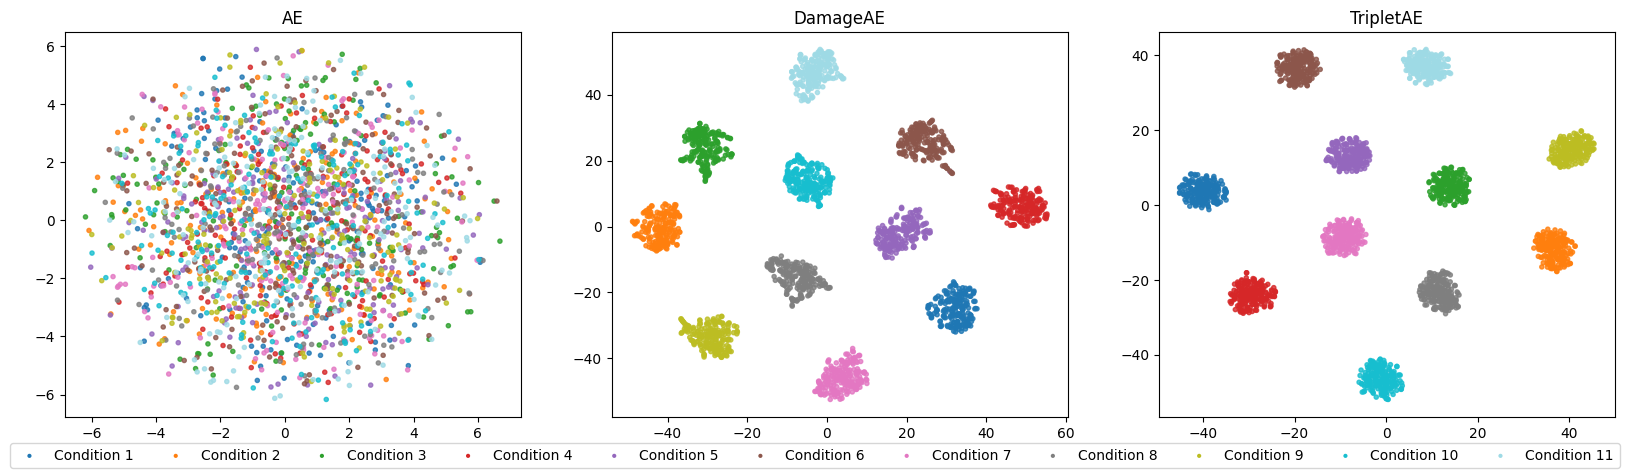

In [6]:
from sklearn.manifold import TSNE
from matplotlib.pyplot import scatter
import matplotlib.cm as cm

cmp = cm.get_cmap('tab20')


fig, ax = plt.subplots(1, 3, figsize=(20, 5))
embedded = TSNE(n_components=2, random_state=0).fit_transform(ae_representation)
ax[0].scatter(embedded[:, 0], embedded[:, 1], c=class_list, marker=".", alpha=0.8, cmap="tab20")
ax[0].set_title("AE")
embedded = TSNE(n_components=2, random_state=0).fit_transform(dae_representation)
ax[1].scatter(embedded[:, 0], embedded[:, 1], c=class_list, marker=".", alpha=0.8, cmap="tab20")
ax[1].set_title("DamageAE")
embedded = TSNE(n_components=2, random_state=0).fit_transform(tae_representation)
ax[2].scatter(embedded[:, 0], embedded[:, 1], c=class_list, marker=".", alpha=0.8, cmap="tab20")
ax[2].set_title("TripletAE")


legend_elements = [scatter(embedded[i*190, 0], embedded[i*190, 1], edgecolors='none', marker='.', c=cmp((i-1)*2)) for i in range(1, 12)]
fig.legend(handles=legend_elements, labels=[f"Condition {i+1}" for i in range(11)], loc ='lower center', ncol=11)
plt.savefig("TSNE.svg", bbox_inches='tight')

In [7]:
signal = dataset[0][0][0].unsqueeze(0)

In [8]:
with torch.no_grad():
    _, ae_reconstruct = ae(signal)
    _, _, dae_reconstruct = dae(signal)
    _, tae_reconstruct = tae(signal)

In [9]:
signal = denormalize(signal).squeeze()
ae_reconstruct = denormalize(ae_reconstruct).squeeze()
dae_reconstruct = denormalize(dae_reconstruct).squeeze()
tae_reconstruct = denormalize(tae_reconstruct).squeeze()

In [10]:
ae_reconstruct.shape

(5, 1024)

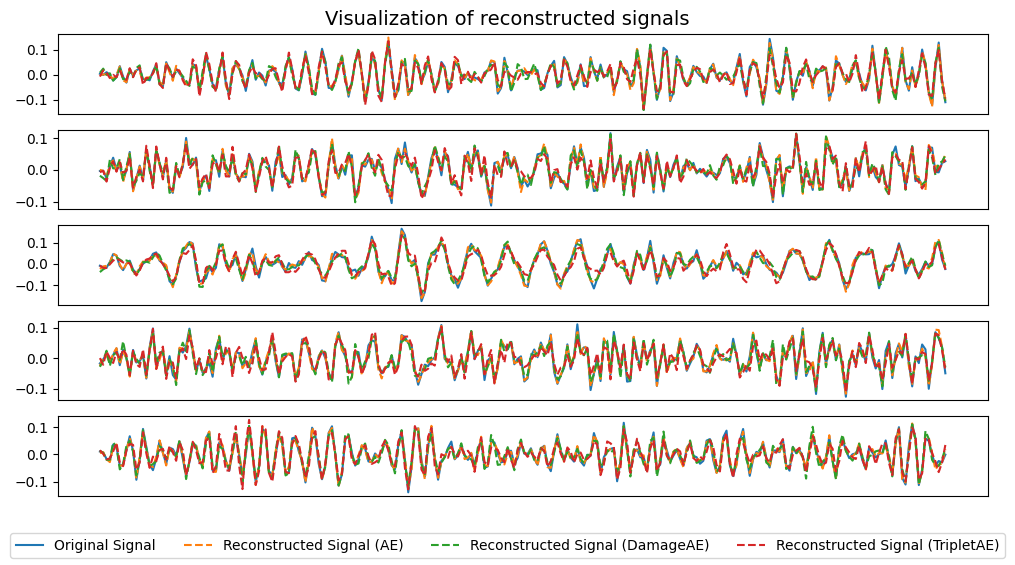

In [11]:
fig, axes = plt.subplots(5, 1, figsize=(12,6))
length = 256
for i in range(5):
    line1 = axes[i].plot(range(len(signal[i, :length])), signal[i, :length], color="tab:blue",  label="Original Signal")
    line2 = axes[i].plot(range(len(ae_reconstruct[i, :length])), ae_reconstruct[i, :length], color="tab:orange", linestyle='dashed', label="Reconstructed Signal (AE)")
    line3 = axes[i].plot(range(len(dae_reconstruct[i, :length])), dae_reconstruct[i, :length], color="tab:green", linestyle='dashed', label="Reconstructed Signal (DamageAE)")
    line4 = axes[i].plot(range(len(tae_reconstruct[i, :length])), tae_reconstruct[i, :length], color="tab:red", linestyle='dashed', label="Reconstructed Signal (TripletAE)")
    axes[i].set_xticks([])
fig.legend(handles =[line1[0], line2[0], line3[0], line4[0]], loc ='lower center', ncol=4)
fig.suptitle('Visualization of reconstructed signals', fontsize=14, y=0.92)

plt.savefig("./pic/reconstructed.svg", bbox_inches='tight')

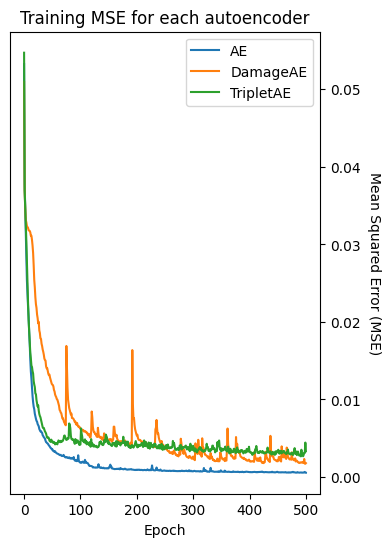

In [12]:
models = ["AE", "DamageAE", "TripletAE"]

fig, ax = plt.subplots(figsize=(4, 6))

for model in models:
    df = pd.read_csv(f"./csv/run-autoencoder_{model}_Final_version_0-tag-Train_Loss_MSE Loss.csv")
    ax.plot(df["Step"], df["Value"], label=model)

ax.legend()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Squared Error (MSE)", rotation=270, labelpad=15)
ax.set_title("Training MSE for each autoencoder")
plt.savefig("./pic/AE_loss.svg", bbox_inches='tight')
plt.show()

In [13]:
df

,Wall time,Step,Value
0,1.681398e+09,0,0.054718
1,1.681398e+09,1,0.036942
2,1.681398e+09,2,0.034776
3,1.681398e+09,3,0.032942
4,1.681398e+09,4,0.030402
...,...,...,...
496,1.681401e+09,496,0.002863
497,1.681401e+09,497,0.003129
498,1.681401e+09,498,0.003109
499,1.681401e+09,499,0.004442
